<a href="https://colab.research.google.com/github/PGM-Lab/probai-2021-pyro/blob/main/Day3/notebooks/student_BBVI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applying BBVI for a simple Gaussian Model

<img src="https://github.com/PGM-Lab/probabilisticAI_tutorials/raw/master/Day3/BBVI_exercise.png">

In [ ]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# Data

In [ ]:
# Generate data from a simple model: Normal(10, 1)
data = np.random.normal(loc = 10, scale = 1, size = 100)

# Helper function: ELBO

Calculate the exact value of the ELBO. Generally one would have to estimate this using sampling, but for this simple model we can evaluate it exactly 

In [ ]:
def calculate_lower_bound(tau, q_mu):
    """
    Helper routine: Calculate ELBO. Data is the sampled x-values, anything without a star relates to the prior,
    everything _with_ a star relates to the variational posterior.
    Note that we have no nu without a star; I am simplifying by forcing this to be zero a priori

    Note: This function obviously only works when the model is as in this code challenge,
    and is not a general solution.

    :param data: The sampled data
    :param tau: prior variance for mu, the mean for the data generation
    :param alpha: prior shape of dist for gamma, the precision  of the data generation
    :param beta: prior rate of dist for gamma, the precision  of the data generation
    :param nu_star: VB posterior mean for the distribution of mu - the mean of the data generation
    :param tau_star: VB posterior precision for the distribution of mu - the mean of the data generation
    :param alpha_star: VB posterior shape of dist for gamma, the precision  of the data generation
    :param beta_star: VB posterior shape of dist for gamma, the precision  of the data generation
    :return: the ELBO
    """

    # We calculate ELBO as E_q log p(x,mu) - E_q log q(mu)
    # log p(x,z) here is log p(mu) + \sum_i log p(x_i | mu, 1)

    # E_q log p(mu)
    log_p = -.5 * np.log(2 * np.pi) - .5 * (1/tau) * (1 + q_mu**2)


    # E_q log p(x_i|mu, 1)
    for xi in data:
        log_p += -.5 * np.log(2 * np.pi) - .5 * (xi * xi - 2 * xi * q_mu + 1 + q_mu**2)

    # Entropy of mu (Gaussian)
    entropy = .5 * np.log(2 * np.pi * np.exp(1))

    return log_p + entropy

# Manual estimation of the gradient of the ELBO for the above model

In [ ]:
# Gradient estimator using sampling -- vanilla BBVI
# We here assume the model X ~ Normal(mu, 1)
# with unknown mu, that in itself is Normal, mean 0 and standard deviation 1000, 
# so effectively an uniformed prior. 
# The variational dstribution for mu is also Normal, with parameter q_mu_lambda
# -- taking the role of lambda in the calculations -- and variance 1.

def grad_estimate(q_mu_lambda, samples = 1):
    # sum_grad_estimate will hold the sum as we move along over the <samples> samples. 
    sum_grad_estimate = 0
    for i in range(samples):
        # Sample one example from current best guess for the variational distribution
        mu_sample = np.random.normal(loc=q_mu_lambda, scale=1, size=1)
        
        # Now we want to calculate the contribution from this sample, namely 
        # [log p(x, mu_sample) - log q(mu_sample|q_mu_lambda) ] * grad( log q(mu_sample|q_mu_lambda) )
        #
        # First log p(x|mu_sample) + log p(mu_sample) - log q(mu_sample|q_mu_lambda) 
        value = np.sum(norm.logpdf(data, loc=mu_sample, scale=1)) 
        + ???
        - ???
        
        # Next grad (log q(mu_sample|q_mu_lambda))
        # The Normal distribution gives the score function with known variance as <value> - <mean>
        grad_q = ???
        
        # grad ELBO for this sample is therefore in total given by
        sum_grad_estimate = sum_grad_estimate + grad_q * value
        
    # Divide by number of samples to get average value -- the estimated expectation  
    return sum_grad_estimate/samples

# Check effect of sample count

In [ ]:
import time
no_loops = 500
sample_counts = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50]
elbos_for_sample_counts = {}
lr = 1E-4


for sample_count in sample_counts:
    ##### Starting point
    q_mu = -10
    start = time.time()
    elbos = []
    #loop a couple of times
    for t in range(no_loops):
        elbos.append(calculate_lower_bound(1000, q_mu))
        q_grad = grad_estimate(q_mu, samples=sample_count)        
        # Adjust learning rate according to the formula <start>/((1 + <t>/100)**1.5)
        q_mu = q_mu + lr * q_grad[0]
    elbos_for_sample_counts[sample_count] = elbos
    print("{:4d} sample(s) -- Estimate: {:9.5f};  --  Calc.time: {:5.2f} sec.".format(
        sample_count, float(q_mu), time.time() - start))

   1 sample(s) -- Estimate:  10.04000;  --  Calc.time:  0.25 sec.
   2 sample(s) -- Estimate:   9.63580;  --  Calc.time:  0.38 sec.
   3 sample(s) -- Estimate:   9.80948;  --  Calc.time:  0.53 sec.
   4 sample(s) -- Estimate:   9.91410;  --  Calc.time:  0.66 sec.
   5 sample(s) -- Estimate:   9.86913;  --  Calc.time:  0.84 sec.
  10 sample(s) -- Estimate:   9.78933;  --  Calc.time:  1.52 sec.
  15 sample(s) -- Estimate:   9.87243;  --  Calc.time:  2.20 sec.
  20 sample(s) -- Estimate:   9.86563;  --  Calc.time:  2.86 sec.
  25 sample(s) -- Estimate:   9.84137;  --  Calc.time:  3.54 sec.
  30 sample(s) -- Estimate:   9.79658;  --  Calc.time:  4.46 sec.
  40 sample(s) -- Estimate:   9.87294;  --  Calc.time:  5.59 sec.
  50 sample(s) -- Estimate:   9.88174;  --  Calc.time:  6.96 sec.
 200 sample(s) -- Estimate:   9.87364;  --  Calc.time: 27.96 sec.


# Plot the evolution of the ELBO

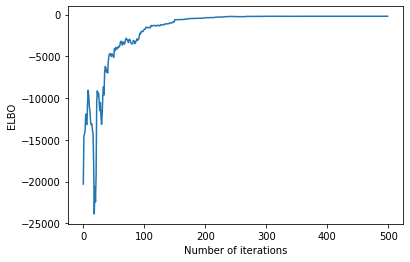

In [ ]:
plt.xlabel('Number of iterations')
plt.ylabel('ELBO')
no_samples = 1
plt.plot(range(no_loops), elbos_for_sample_counts[no_samples])

# Checking the variation in gradient estimate

M =  1 sample(s) in BBVI -- Mean of gradient:  77.634; Std.dev. of gradient: 359.081
M =  2 sample(s) in BBVI -- Mean of gradient:  88.942; Std.dev. of gradient: 271.742
M =  3 sample(s) in BBVI -- Mean of gradient: 102.361; Std.dev. of gradient: 227.857
M =  4 sample(s) in BBVI -- Mean of gradient:  94.095; Std.dev. of gradient: 179.573
M =  5 sample(s) in BBVI -- Mean of gradient: 102.530; Std.dev. of gradient: 178.506
M = 10 sample(s) in BBVI -- Mean of gradient:  98.008; Std.dev. of gradient: 120.222
M = 25 sample(s) in BBVI -- Mean of gradient:  92.750; Std.dev. of gradient:  74.892


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


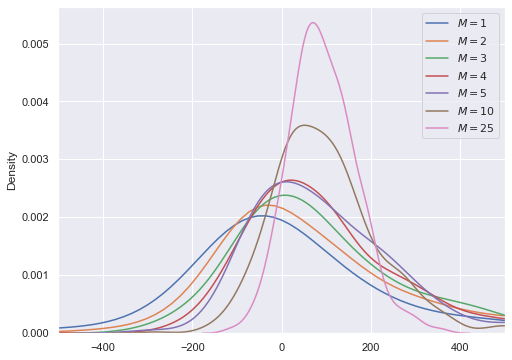

In [ ]:
# To check the variation / "unreliability" of the gradient estimate we repeat 
# several times for the same lambda value and notice difference

# Location to check -- close to the data mean (at +10). 
# The prior will move the variational optimium **slightly** away from the data mean, 
# but due to the large prior variance of mu this should be a very limited effect.
# We should therefore expect a positive derivative (since we want to move 
# q_mu_lambda towards the data mean, that is, **increase** it)
q_mu_lambda = 9

plt.figure(figsize=(8,6))
sns.set()
# Do with different sample sizes
for sample_count in [1, 2, 3, 4, 5, 10, 25]:

    #loop
    q_grad = []
    for t in range(500):
        q_grad.append(grad_estimate(q_mu_lambda, samples=sample_count))
    
    sns.distplot(q_grad, hist=False, label="$M = {:d}$".format(sample_count))
    
    # Report back
    print("M = {:2d} sample(s) in BBVI -- Mean of gradient: {:7.3f}; Std.dev. of gradient: {:7.3f}".format(
        sample_count, np.mean(q_grad), np.std(q_grad)))

plt.xlim([-500, 500])
plt.legend()
plt.savefig('BBVI-gradient-variance.eps')
plt.show()      

